In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf

import mgwr

# script file, not a module 
import utils

In [78]:
gdf = gpd.read_file('..\\output\\model_in1.GEOJSON', engine='pyogrio', use_arrow=True)

In [76]:
gdf['rt_busway'].value_counts().min()

64

In [79]:
cols = gdf.columns
print(len(cols))
for col in cols:
    vc = gdf[col].value_counts()
    if len(vc) < 2:
        print(col)
        del gdf[col]
    if len(vc) == 2 and vc.min() < 100:
        print('-', col)
        del gdf[col]
print(len(gdf.columns))

20
- junction
rt_highway
rt_trunk
rt_primary
- rt_secondary
- rt_unclassified
- rt_busway
13


<Axes: >

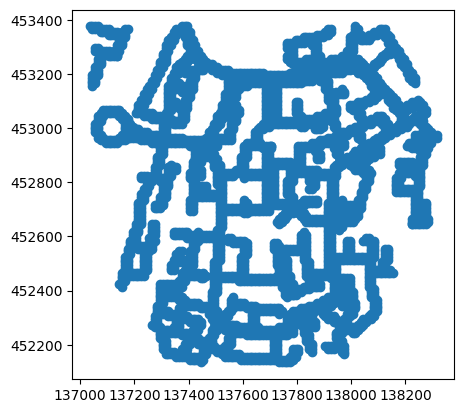

In [14]:
gdf.plot()

In [53]:
from sklearn.model_selection import train_test_split
gdf_train, gdf_test = train_test_split(gdf[gdf['dBA_reg'].notna()], test_size=0.2)
gdf_val = gdf[gdf['dBA_reg'].isna()]

In [16]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

In [17]:
gdf_train

,x,y,dBA_rivm,dBA_raw,dBA_reg,maxspeed,highway,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,geometry
3144,137495.0,452455.0,66,87.841622,67.671219,50,tertiary,False,False,False,False,False,False,True,False,False,False,False,False,POINT (137495.000 452455.000)
1119,138195.0,453045.0,65,83.981572,72.067805,50,tertiary,False,False,False,False,False,False,True,False,False,False,False,False,POINT (138195.000 453045.000)
3827,137755.0,452255.0,63,76.559921,66.030418,50,tertiary,False,False,False,False,False,False,True,False,False,False,False,False,POINT (137755.000 452255.000)
378,137965.0,453235.0,65,87.982718,69.793517,50,tertiary,False,False,False,False,False,False,True,False,False,False,False,False,POINT (137965.000 453235.000)
970,137525.0,453075.0,68,91.247714,68.969472,50,tertiary,True,False,False,False,False,False,True,False,False,False,False,False,POINT (137525.000 453075.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,138065.0,453215.0,64,85.831169,69.458128,50,tertiary,False,False,False,False,False,False,True,False,False,False,False,False,POINT (138065.000 453215.000)
1983,137685.0,452835.0,51,67.207019,61.339243,15,living_street,False,False,False,False,False,False,False,False,False,True,False,False,POINT (137685.000 452835.000)
2704,137505.0,452595.0,67,66.889205,62.398846,30,residential,False,False,False,False,False,False,False,False,True,False,False,False,POINT (137505.000 452595.000)
1491,137135.0,452955.0,72,82.286103,75.541630,50,secondary,False,True,False,False,False,True,False,False,False,False,False,False,POINT (137135.000 452955.000)


In [18]:
gdf.columns

Index(['x', 'y', 'dBA_rivm', 'dBA_raw', 'dBA_reg', 'maxspeed', 'highway',
       'bridge', 'junction', 'rt_highway', 'rt_trunk', 'rt_primary',
       'rt_secondary', 'rt_tertiary', 'rt_unclassified', 'rt_residential',
       'rt_living_street', 'rt_busway', 'rt_service', 'geometry'],
      dtype='object')

In [81]:
from sklearn.model_selection import train_test_split
gdf_train, gdf_test = train_test_split(gdf[gdf['dBA_reg'].notna()], test_size=0.2)
gdf_val = gdf[gdf['dBA_reg'].isna()]
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
scaler = StandardScaler()

x_cols = ['maxspeed', 'bridge', 'junction', 'rt_highway', 'rt_trunk', 'rt_primary', 'rt_secondary', 'rt_tertiary', 'rt_unclassified', 'rt_residential', 'rt_living_street', 'rt_busway', 'rt_service']
cal = gdf_train
cal_coords = np.dstack((cal['x'], cal['y']))[0]

cal_y = np.vstack(cal['dBA_reg'])
cal_X = np.dstack(list(cal[col] for col in x_cols if col in cal.columns))[0]
x_standardized = scaler.fit_transform(cal_X)
cal_X

array([[50,  1,  1,  0,  0,  0],
       [50,  0,  1,  0,  0,  0],
       [50,  0,  1,  0,  0,  0],
       ...,
       [50,  0,  1,  0,  0,  0],
       [30,  0,  0,  1,  0,  0],
       [50,  0,  1,  0,  0,  0]])

In [98]:
cal = gdf_test
val_y = np.vstack(cal['dBA_reg'])
val_X = np.dstack(list(cal[col] for col in x_cols if col in cal.columns))[0]
val_X = scaler.fit_transform(val_X)
val_coords= np.dstack((cal['x'], cal['y']))[0]

In [156]:
list([col] for col in x_cols if col in cal.columns)

[['maxspeed'],
 ['bridge'],
 ['rt_tertiary'],
 ['rt_residential'],
 ['rt_living_street'],
 ['rt_service']]

In [115]:
gdf.to_file("..\\output\\modelin2.GEOJSON")

In [114]:
cal.columns

Index(['x', 'y', 'dBA_rivm', 'dBA_raw', 'dBA_reg', 'maxspeed', 'highway',
       'bridge', 'rt_tertiary', 'rt_residential', 'rt_living_street',
       'rt_service', 'geometry'],
      dtype='object')

In [103]:
model = GWR(cal_coords, cal_y, x_standardized, bw=94, fixed=False, kernel='bisquare')
model.fit()
results = model.predict(val_coords, val_X)

In [113]:
print(predc.shape, predx.shape)

(3539, 2) (3539, 6)


In [150]:
cal = gdf_val
predy = np.vstack(cal['dBA_reg'])[:200]
predx = np.dstack(list(cal[col] for col in x_cols if col in cal.columns))[0]
predx = scaler.fit_transform(predx)[:200]
predc = np.dstack((cal['x'], cal['y']))[0][:200]
model = GWR(cal_coords, cal_y, x_standardized, bw=94, fixed=False, kernel='bisquare')
preds = model.predict(predc, predx)

In [153]:
preds.predy

array([[69.55177066],
       [71.32067618],
       [69.39660102],
       [70.32155214],
       [70.38946853],
       [69.728484  ],
       [68.53615718],
       [68.82585878],
       [69.64151441],
       [69.80385895],
       [70.79045891],
       [71.67581405],
       [70.73843449],
       [69.75908945],
       [68.18200483],
       [70.47697328],
       [69.75941403],
       [68.9105334 ],
       [69.00825244],
       [68.70118188],
       [68.56216201],
       [69.08794811],
       [66.56321076],
       [68.95062073],
       [67.45711845],
       [69.92003758],
       [68.5637482 ],
       [69.63891102],
       [68.84798486],
       [71.62895718],
       [71.69748697],
       [68.26445979],
       [68.13911568],
       [71.62748127],
       [70.04679667],
       [71.48924017],
       [69.9383027 ],
       [70.05054894],
       [70.29960495],
       [68.69926135],
       [69.28739535],
       [70.42846323],
       [68.50686283],
       [69.20244524],
       [70.09610684],
       [68

In [155]:
for i in range(len(preds.predy)):
    print(predy[i], preds.predy[i])

[nan] [69.55177066]
[nan] [71.32067618]
[nan] [69.39660102]
[nan] [70.32155214]
[nan] [70.38946853]
[nan] [69.728484]
[nan] [68.53615718]
[nan] [68.82585878]
[nan] [69.64151441]
[nan] [69.80385895]
[nan] [70.79045891]
[nan] [71.67581405]
[nan] [70.73843449]
[nan] [69.75908945]
[nan] [68.18200483]
[nan] [70.47697328]
[nan] [69.75941403]
[nan] [68.9105334]
[nan] [69.00825244]
[nan] [68.70118188]
[nan] [68.56216201]
[nan] [69.08794811]
[nan] [66.56321076]
[nan] [68.95062073]
[nan] [67.45711845]
[nan] [69.92003758]
[nan] [68.5637482]
[nan] [69.63891102]
[nan] [68.84798486]
[nan] [71.62895718]
[nan] [71.69748697]
[nan] [68.26445979]
[nan] [68.13911568]
[nan] [71.62748127]
[nan] [70.04679667]
[nan] [71.48924017]
[nan] [69.9383027]
[nan] [70.05054894]
[nan] [70.29960495]
[nan] [68.69926135]
[nan] [69.28739535]
[nan] [70.42846323]
[nan] [68.50686283]
[nan] [69.20244524]
[nan] [70.09610684]
[nan] [68.892754]
[nan] [69.66770756]
[nan] [68.68537156]
[nan] [69.41275902]
[nan] [67.65673537]
[nan] [

In [94]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sample data for illustration; replace with your actual data
# Assuming x and y are your input arrays
x = np.random.rand(472, 13)
y = np.random.rand(472, 1)

# Check for zero variance columns
zero_variance_columns = np.where(np.var(x, axis=0) == 0)[0]
if zero_variance_columns.size > 0:
    print(f"Columns with zero variance: {zero_variance_columns}")

# Remove duplicate rows
df = pd.DataFrame(np.hstack((x, y)))
df = df.drop_duplicates()
x = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Standardize the data
scaler = StandardScaler()
x_standardized = scaler.fit_transform(x)

# Check for multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data["feature"] = [f"x{i}" for i in range(x_standardized.shape[1])]
vif_data["VIF"] = [variance_inflation_factor(x_standardized, i) for i in range(x_standardized.shape[1])]
print(vif_data)

# If any VIF values are high, consider removing or combining variables
# For this example, we proceed assuming no high VIFs

# Ensure y is a 1D array
y = y.ravel()

# Proceed with MGWR
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW

# Coordinates (replace with your actual coordinate data)
coords = np.random.rand(472, 2)  # Example coordinates

# Bandwidth selection
gwr_selector = Sel_BW(coords, y, x_standardized)
gwr_bw = gwr_selector.search(bw_min=100)

# Running MGWR
model = GWR(coords, y, x_standardized, bw=gwr_bw)
results = model.fit()

print(results.summary())


   feature       VIF
0       x0  1.014083
1       x1  1.037322
2       x2  1.023817
3       x3  1.038595
4       x4  1.014368
5       x5  1.034961
6       x6  1.017637
7       x7  1.008957
8       x8  1.014383
9       x9  1.043710
10     x10  1.048698
11     x11  1.029594
12     x12  1.039354


IndexError: invalid index to scalar variable.

In [93]:
gwr_selector = Sel_BW(cal_coords, cal_y, x_standardized)
gwr_bw = gwr_selector.search(bw_min=100)
print(gwr_bw)
model = GWR(cal_coords, cal_y, cal_X, gwr_bw)
gwr_results = model.fit()

LinAlgError: Matrix is singular.

In [ ]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = model.predict(pred_coords, pred_X, scale, residuals)

fucking with matrixes

In [84]:
from spreg import OLS
r = OLS(cal_y, cal_X)

In [86]:
r.results()

AttributeError: 'OLS' object has no attribute 'results'

In [30]:
gdf_train.describe()

,x,y,dBA_rivm,dBA_raw,dBA_reg,maxspeed
count,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,137674.766949,452711.207627,61.300847,81.093608,67.563801,41.483051
std,274.842068,349.296872,6.865910,8.739824,4.715726,12.840841
min,137065.000000,452155.000000,47.000000,64.395190,56.458654,15.000000
25%,137485.000000,452352.500000,55.000000,71.786399,63.521938,30.000000
50%,137650.000000,452750.000000,62.000000,84.073722,68.326123,50.000000
75%,137925.000000,452995.000000,67.000000,88.640990,71.335745,50.000000
max,138205.000000,453255.000000,75.000000,94.155703,81.080577,50.000000


In [28]:
gdf_train.dropna().shape

(472, 20)

In [87]:
import numpy as np
x = cal_X
y = cal_y
# Assuming x and y are your input arrays
# Check for NaN or Infinite values
if np.isnan(x).any() or np.isnan(y).any():
    print("NaN values found in the input arrays.")
if np.isinf(x).any() or np.isinf(y).any():
    print("Infinite values found in the input arrays.")

# Check data types
print(f"x dtype: {x.dtype}, y dtype: {y.dtype}")

# Optionally, you can cast your data to a safe dtype
x = x.astype(np.float64)
y = y.astype(np.float64)

# Verify shapes
print(f"x shape: {x.shape}, y shape: {y.shape}")


x dtype: int32, y dtype: float64
x shape: (472, 6), y shape: (472, 1)


In [88]:
import spreg

# Ensure that y is in the correct shape (472,)
y = y.ravel()

# Run OLS regression
ols_model = spreg.OLS(y, x)
print(ols_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:         472
Mean dependent var  :     67.4700                Number of Variables   :           7
S.D. dependent var  :      4.7038                Degrees of Freedom    :         465
R-squared           :      0.4756
Adjusted R-squared  :      0.4688
Sum squared residual:     5464.83                F-statistic           :     70.2863
Sigma-square        :      11.752                Prob(F-statistic)     :   4.156e-62
S.E. of regression  :       3.428                Log likelihood        :   -1247.729
Sigma-square ML     :      11.578                Akaike info criterion :    2509.458
S.E of regression ML:      3.4027                Schwarz criterion     :    2538.557

------------------------------------------------------------

In [37]:
x

array([[50.,  0.,  0., ...,  0.,  0.,  0.],
       [50.,  0.,  0., ...,  0.,  0.,  0.],
       [50.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [30.,  0.,  0., ...,  0.,  0.,  0.],
       [50.,  0.,  1., ...,  0.,  0.,  0.],
       [30.,  0.,  0., ...,  0.,  0.,  0.]])

In [89]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Checking for zero variance columns in x
zero_variance_columns = np.where(np.var(x, axis=0) == 0)[0]
if zero_variance_columns.size > 0:
    print(f"Columns with zero variance: {zero_variance_columns}")
print([x_cols[i] for i in zero_variance_columns])
# Standardizing the data
scaler = StandardScaler()
x_standardized = scaler.fit_transform(x)

# Run OLS regression
import spreg
# Ensure y is a 1D array
y = y.ravel()

try:
    ols_model = spreg.OLS(y, x_standardized)
    print(ols_model.summary)
except Exception as e:
    print(f"Error: {e}")


[]
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:         472
Mean dependent var  :     67.4700                Number of Variables   :           7
S.D. dependent var  :      4.7038                Degrees of Freedom    :         465
R-squared           :      0.4756
Adjusted R-squared  :      0.4688
Sum squared residual:     5464.83                F-statistic           :     70.2863
Sigma-square        :      11.752                Prob(F-statistic)     :   4.156e-62
S.E. of regression  :       3.428                Log likelihood        :   -1247.729
Sigma-square ML     :      11.578                Akaike info criterion :    2509.458
S.E of regression ML:      3.4027                Schwarz criterion     :    2538.557

---------------------------------------------------------

In [91]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = [f"x{i}" for i in range(x_standardized.shape[1])]

vif_data["VIF"] = [variance_inflation_factor(x_standardized, i) for i in range(x_standardized.shape[1])]

print(vif_data)


  feature        VIF
0      x0  29.992800
1      x1   1.070627
2      x2   5.741128
3      x3  14.679177
4      x4  28.062096
5      x5   1.515928


In [92]:
# Let's assume x2 has high multicollinearity and needs to be removed
x_reduced = np.delete(x_standardized, 5, axis=1)
ols_model = spreg.OLS(y, x_reduced)

# Re-run the OLS regression with reduced predictors
try:
    ols_model = spreg.OLS(y, x_reduced)
    print(ols_model.summary)
except Exception as e:
    print(f"Error: {e}")


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:         472
Mean dependent var  :     67.4700                Number of Variables   :           6
S.D. dependent var  :      4.7038                Degrees of Freedom    :         466
R-squared           :      0.4756
Adjusted R-squared  :      0.4700
Sum squared residual:     5464.84                F-statistic           :     84.5249
Sigma-square        :      11.727                Prob(F-statistic)     :   4.289e-63
S.E. of regression  :       3.424                Log likelihood        :   -1247.729
Sigma-square ML     :      11.578                Akaike info criterion :    2507.458
S.E of regression ML:      3.4027                Schwarz criterion     :    2532.400

------------------------------------------------------------

In [65]:
print(len(x_cols))
x_cols


13


['maxspeed',
 'bridge',
 'junction',
 'rt_highway',
 'rt_trunk',
 'rt_primary',
 'rt_secondary',
 'rt_tertiary',
 'rt_unclassified',
 'rt_residential',
 'rt_living_street',
 'rt_busway',
 'rt_service']

In [51]:
gdf

,x,y,dBA_rivm,dBA_raw,dBA_reg,maxspeed,highway,bridge,junction,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,geometry
0,137035.0,453375.0,54,NaN,NaN,30,residential,False,False,False,False,False,True,False,False,False,POINT (137035.000 453375.000)
1,137045.0,453375.0,54,NaN,NaN,30,residential,False,False,False,False,False,True,False,False,False,POINT (137045.000 453375.000)
2,137055.0,453375.0,54,NaN,NaN,30,residential,False,False,False,False,False,True,False,False,False,POINT (137055.000 453375.000)
3,137065.0,453375.0,54,NaN,NaN,30,residential,False,False,False,False,False,True,False,False,False,POINT (137065.000 453375.000)
4,137375.0,453375.0,65,NaN,NaN,30,residential,False,False,False,False,False,True,False,False,False,POINT (137375.000 453375.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,137735.0,452135.0,53,NaN,NaN,15,living_street,False,False,False,False,False,False,True,False,False,POINT (137735.000 452135.000)
4126,137745.0,452135.0,53,NaN,NaN,15,living_street,False,False,False,False,False,False,True,False,False,POINT (137745.000 452135.000)
4127,137755.0,452135.0,54,NaN,NaN,15,living_street,False,False,False,False,False,False,True,False,False,POINT (137755.000 452135.000)
4128,137765.0,452135.0,54,NaN,NaN,15,living_street,False,False,False,False,False,False,True,False,False,POINT (137765.000 452135.000)


In [50]:
gdf['rt_highway'].value_counts()

KeyError: 'rt_highway'

In [133]:
from pysal.lib import weights
from pysal.model import spreg

In [141]:
variable_names = ['maxspeed', 'bridge', 'rt_tertiary', 'rt_residential', 'rt_living_street', 'rt_service']
for col in variable_names+['dBA_reg']:
    gdf_train[col] = pd.to_numeric(gdf_train[col])


In [142]:
gdf_train.dtypes

x                    float64
y                    float64
dBA_rivm               int32
dBA_raw              float64
dBA_reg              float64
maxspeed               int32
highway               object
bridge                  bool
rt_tertiary             bool
rt_residential          bool
rt_living_street        bool
rt_service              bool
geometry            geometry
dtype: object

In [143]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    gdf_train[["dBA_reg"]].values,
    # Independent variables
    gdf_train[variable_names].astype('float64').values,
    # Dependent variable name
    name_y="dBA_reg",
    # Independent variable name
    name_x=variable_names,
)
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dBA_reg                Number of Observations:         472
Mean dependent var  :     67.4700                Number of Variables   :           7
S.D. dependent var  :      4.7038                Degrees of Freedom    :         465
R-squared           :      0.4756
Adjusted R-squared  :      0.4688
Sum squared residual:     5464.83                F-statistic           :     70.2863
Sigma-square        :      11.752                Prob(F-statistic)     :   4.156e-62
S.E. of regression  :       3.428                Log likelihood        :   -1247.729
Sigma-square ML     :      11.578                Akaike info criterion :    2509.458
S.E of regression ML:      3.4027                Schwarz criterion     :    2538.557

------------------------------------------------------------

In [144]:
knn = weights.KNN.from_dataframe(gdf_train, k=10)

m7 = spreg.GM_Error_Het(
    # Dependent variable
    gdf_train[["dBA_reg"]].values,
    # Independent variables
    gdf_train[variable_names].astype('float64').values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="dBA_reg",
    # Independent variable name
    name_x=variable_names,
)
print(m7.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES (HET)
------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dBA_reg                Number of Observations:         472
Mean dependent var  :     67.4700                Number of Variables   :           7
S.D. dependent var  :      4.7038                Degrees of Freedom    :         465
Pseudo R-squared    :      0.4526
N. of iterations    :           1                Step1c computed       :          No

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        62.60916         3.21880        19.45106         0.00000
            maxspeed         0.10161         0.06204    

In [146]:
m8 = spreg.GM_Lag(
    # Dependent variable
    gdf_train[["dBA_reg"]].values,
    # Independent variables
    gdf_train[variable_names].astype('float64').values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="dBA_reg",
    # Independent variable name
    name_x=variable_names,
)
print(m8.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dBA_reg                Number of Observations:         472
Mean dependent var  :     67.4700                Number of Variables   :           8
S.D. dependent var  :      4.7038                Degrees of Freedom    :         464
Pseudo R-squared    :      0.7155
Spatial Pseudo R-squared:  0.4999

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         5.05082         5.57912         0.90531         0.36530
            maxspeed        -0.00067         0.05161        -0.01290         0.98971
              bridge         0.26887      

In [149]:
from sklearn.metrics import mean_squared_error as mse

pd.Series({'M1': mse(gdf_train[["dBA_reg"]].values, m1.predy.flatten()), \
                     'M7': mse(gdf_train[["dBA_reg"]].values, m7.predy.flatten()), \
                     'M8': mse(gdf_train[["dBA_reg"]].values, m8.predy.flatten())
                    })

M1    11.578039
M7    14.857287
M8     6.282294
dtype: float64